<a href="https://colab.research.google.com/github/SudhaRaj12/Brainwave_Matrix_Intern/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing the librarires
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud
from collections import Counter

In [66]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [67]:
# Load spaCy model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

In [69]:
"""Processes Instagram dataset, performs sentiment analysis, topic modeling, and visualization."""
instagram_data = pd.read_csv("instagram_dataset.csv")
if 'comment' not in instagram_data.columns:
  raise ValueError("Dataset must contain a 'comment' column.")

In [70]:
# Instagram logo - color palatte
instagram_color=['#405DE6','#00AAB6','#A32CC4','#D62976','#F77737','#FBB034','#FCAF45','#FEDD00']

In [71]:
# Preprocess comments
instagram_data['processed_comment'] = instagram_data['comment'].apply(preprocess_text)

In [72]:
# Pre-processing the text
def preprocess_text(text):
    """Preprocesses text: lowercasing, removing special characters, tokenization, stopword removal."""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

In [73]:
# Analyzing the text
def analyze_sentiment(text):
    """Analyzes sentiment using VADER SentimentIntensityAnalyzer."""
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    if sentiment_scores['compound'] >= 0.05:
        return "Positive"
    elif sentiment_scores['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

In [74]:
def extract_subjectivity(text):
    """Extracts subjectivity score using TextBlob."""
    return TextBlob(text).sentiment.subjectivity

In [75]:
def extract_polarity(text):
    """Extracts polarity score using TextBlob."""
    return TextBlob(text).sentiment.polarity

In [76]:
def extract_entities(text):
    """Extracts Named Entities using spaCy NER."""
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

In [83]:
def generate_wordcloud(df, sentiment):
    """Generates word cloud for the specified sentiment category."""
    text = ' '.join(df[df['Sentiment'] == sentiment]['processed_comment'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.show()

In [78]:
# Analyze Sentiment
instagram_data['Sentiment'] = instagram_data['processed_comment'].apply(analyze_sentiment)
instagram_data['Subjectivity'] = instagram_data['processed_comment'].apply(extract_subjectivity)
instagram_data['Polarity'] = instagram_data['processed_comment'].apply(extract_polarity)
instagram_data['Named_Entities'] = instagram_data['comment'].apply(extract_entities)

<ipython-input-79-b858f337e476>:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=instagram_data, x='post_type', hue='Sentiment', order=instagram_data['post_type'].value_counts().index, palette=instagram_color)


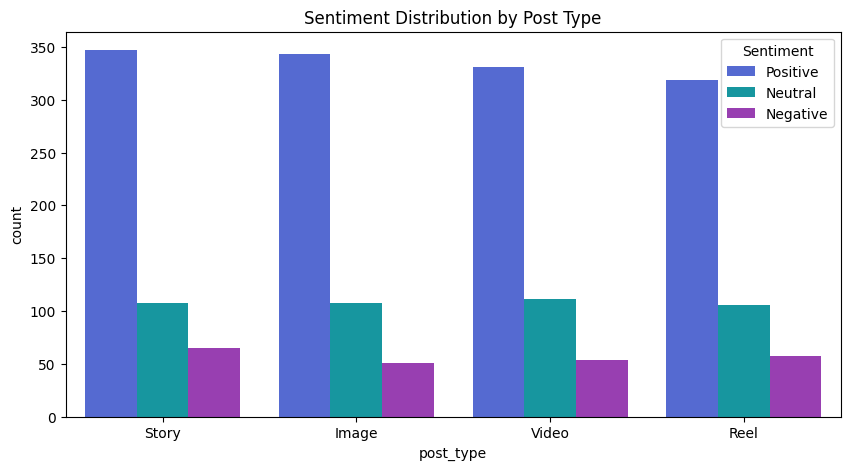

In [79]:
# Sentiment Distribution by Post Type
plt.figure(figsize=(10, 5))
sns.countplot(data=instagram_data, x='post_type', hue='Sentiment', order=instagram_data['post_type'].value_counts().index, palette=instagram_color)
plt.title('Sentiment Distribution by Post Type')
plt.show()

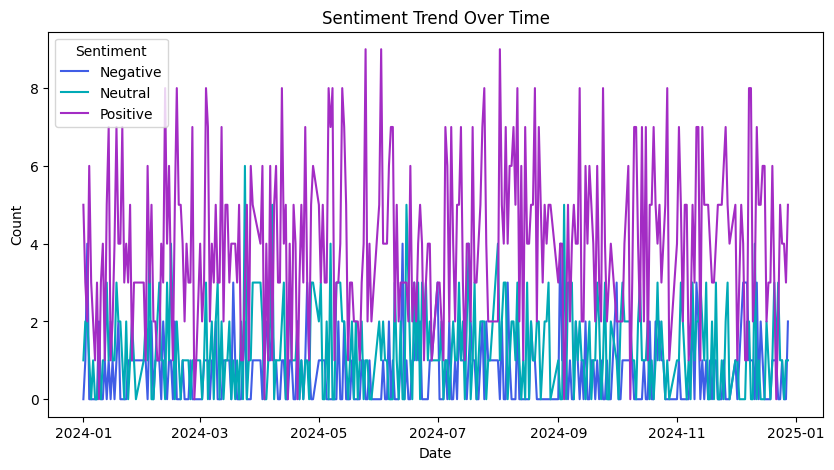

In [80]:
# Convert timestamp to datetime
instagram_data['timestamp'] = pd.to_datetime(instagram_data['timestamp'])
instagram_data['date'] = instagram_data['timestamp'].dt.date
# Sentiment Trend Over Time
sentiment_trend = instagram_data.groupby(['date', 'Sentiment']).size().unstack().fillna(0)
sentiment_trend.plot(kind='line', figsize=(10, 5), title='Sentiment Trend Over Time', color=instagram_color)
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

<ipython-input-81-518ed8db58d5>:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.countplot(data=instagram_data, x='topic', hue='Sentiment', order=instagram_data['topic'].value_counts().index, palette=instagram_color)


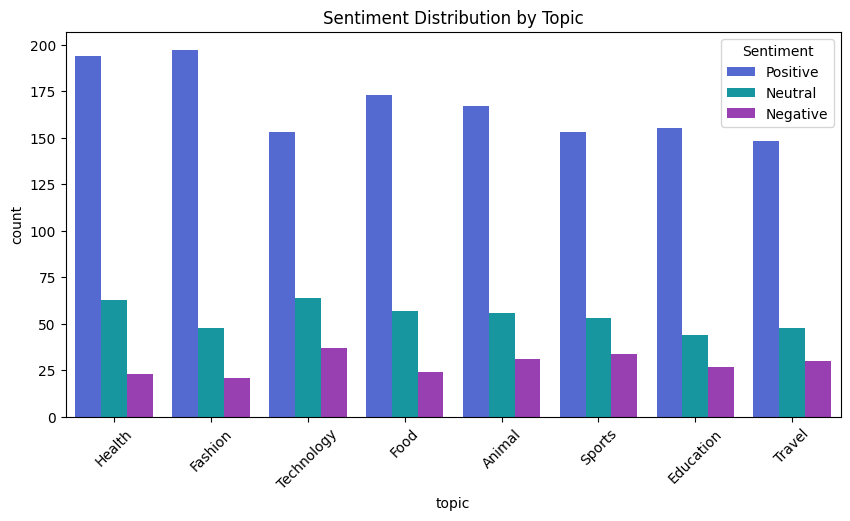

In [81]:
# Sentiment Breakdown by Topic
plt.figure(figsize=(10, 5))
sns.countplot(data=instagram_data, x='topic', hue='Sentiment', order=instagram_data['topic'].value_counts().index, palette=instagram_color)
plt.xticks(rotation=45)
plt.title('Sentiment Distribution by Topic')
plt.show()

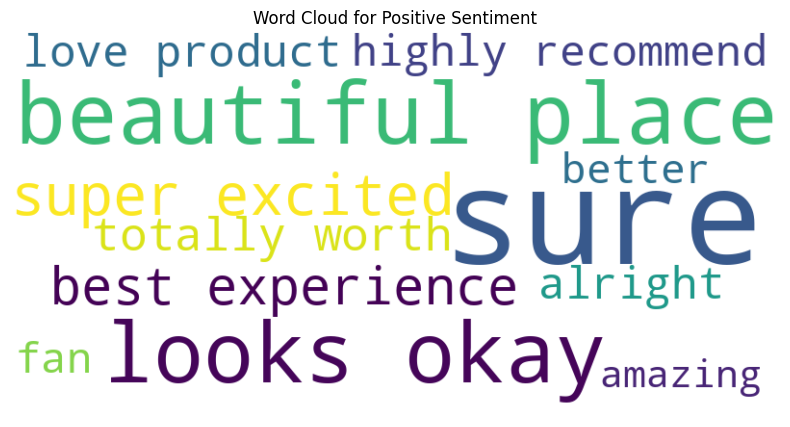

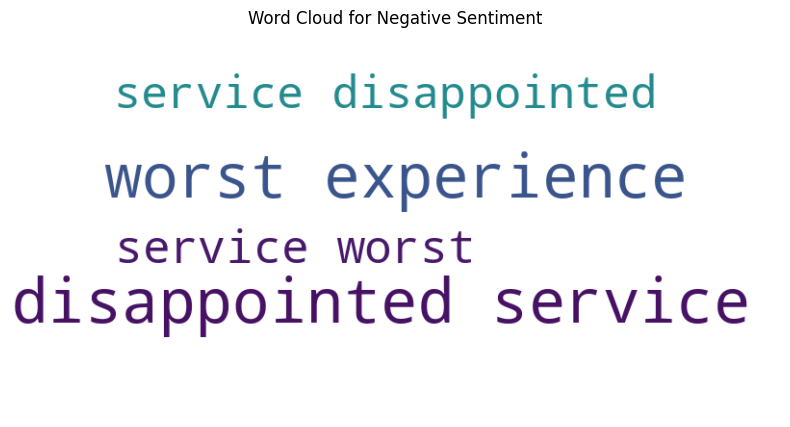

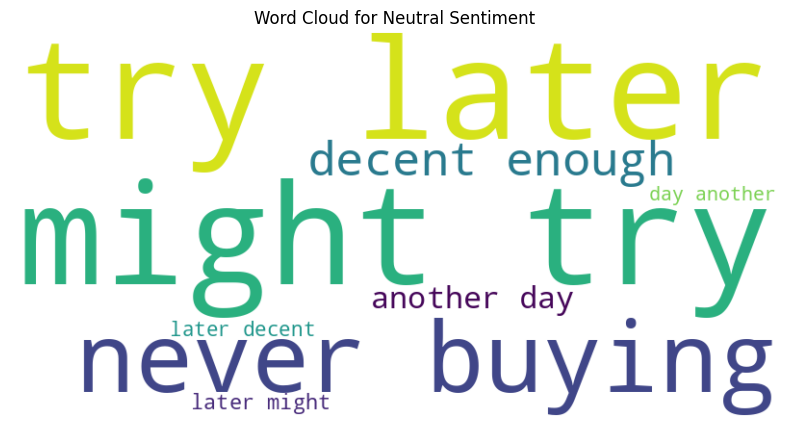

In [84]:
# Generate Word Clouds for each sentiment category
for sentiment in ['Positive', 'Negative', 'Neutral']:
  generate_wordcloud(instagram_data, sentiment)

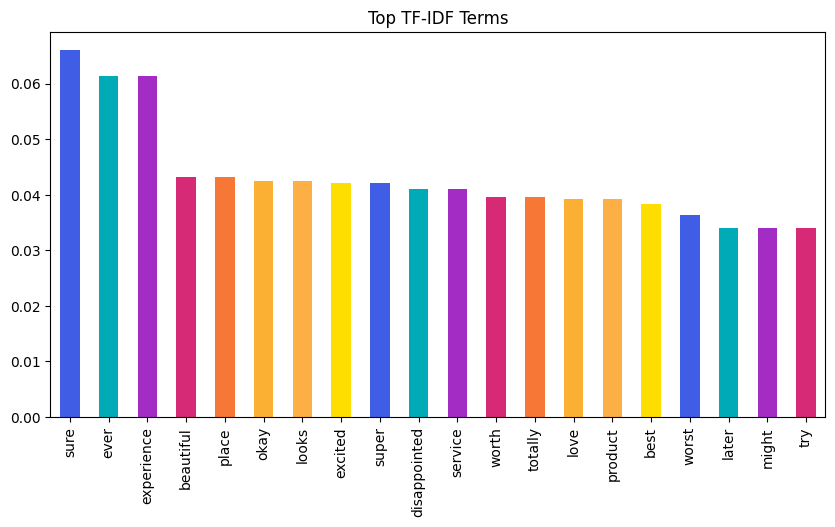

In [85]:
# TF-IDF Analysis
vectorizer = TfidfVectorizer(max_features=20)
tfidf_matrix = vectorizer.fit_transform(instagram_data['processed_comment'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df.mean().sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), title='Top TF-IDF Terms',color=instagram_color)
plt.show()

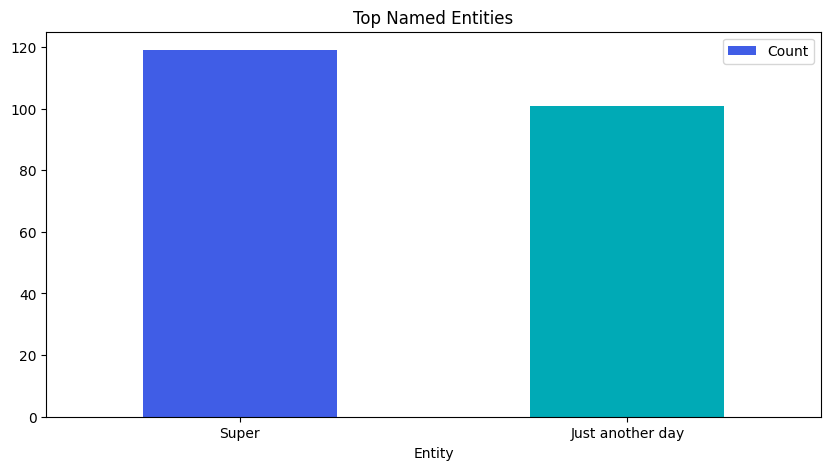

In [86]:
# Extract most common named entities
all_entities = [ent for sublist in instagram_data['Named_Entities'] for ent in sublist]
entity_counts = Counter(all_entities).most_common(10)
entity_df = pd.DataFrame(entity_counts, columns=['Entity', 'Count'])
entity_df.plot(kind='bar', x='Entity', y='Count', figsize=(10, 5), title='Top Named Entities',color=instagram_color)
# rotate the x and y
plt.xticks(rotation=360)
plt.show()

Post by Month: month
August       197
November     179
July         173
October      170
June         168
April        165
September    165
December     164
March        161
May          158
February     154
January      146
Name: count, dtype: int64


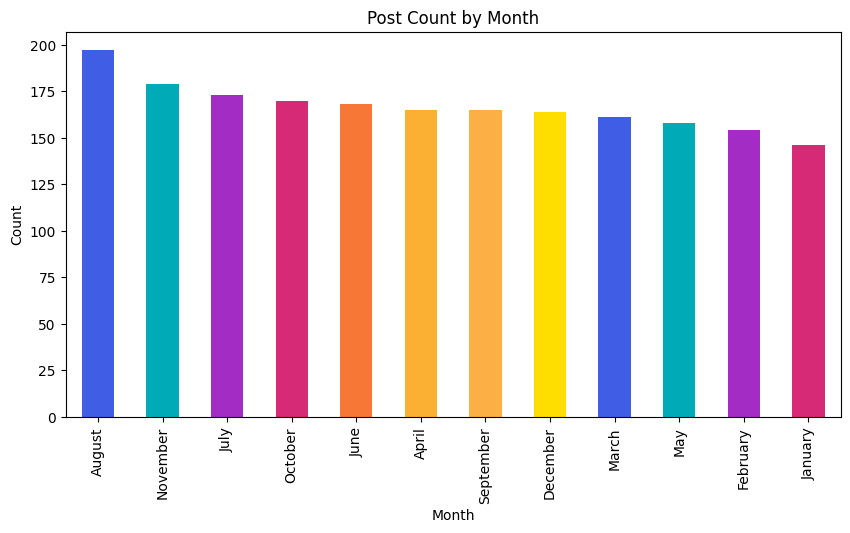

In [87]:
# Count of post by month
import calendar
instagram_data['month'] = instagram_data['timestamp'].dt.month.apply(lambda x: calendar.month_name[x])
post_count_by_month = instagram_data['month'].value_counts()
print('Post by Month:',post_count_by_month)
post_count_by_month.plot(kind='bar', figsize=(10, 5), title='Post Count by Month',color=instagram_color)
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

Post Type Counts: post_type
Story    520
Image    502
Video    496
Reel     482
Name: count, dtype: int64


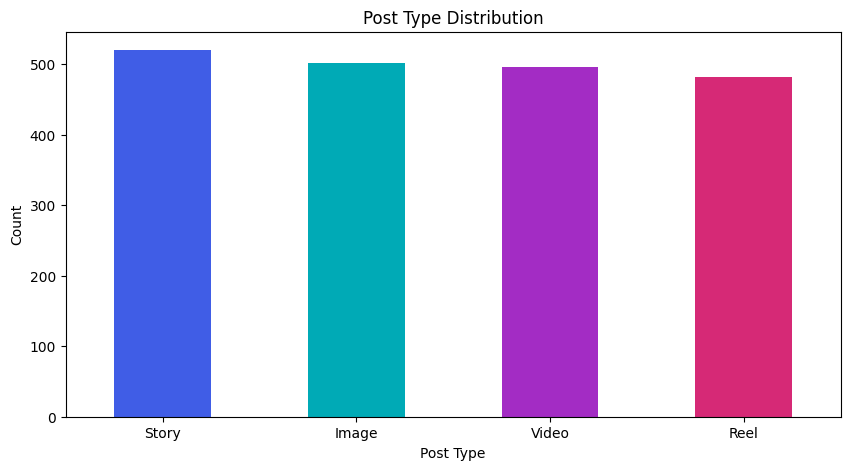

In [88]:
# Type of post count
post_type_counts = instagram_data['post_type'].value_counts()
print("Post Type Counts:",post_type_counts)

# Post Type Distribution by Count
post_type_counts.plot(kind='bar', figsize=(10,5), title='Post Type Distribution', color=instagram_color)
plt.xlabel('Post Type')
plt.ylabel('Count')
plt.xticks(rotation=360)
plt.show()